In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plusmodules as pm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

###  Data Understanding

**Reading Data**

In [21]:
df=pd.read_csv('indicator_estimated_prevalence_150.csv')

In [22]:
df.shape #150 rows, 20 columns

(150, 20)

In [23]:
df.head()

,"TB prevalence, all forms (per 100 000 population per year)",1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,class
0,Slovakia,55,56,59,59,56,51,46,42,38,35,32,30,29,26,25,21,20,20,1
1,Burkina Faso,179,196,208,221,233,246,251,271,286,308,338,368,398,419,426,421,411,403,2
2,Kyrgyzstan,90,93,93,93,101,118,141,165,147,146,156,169,153,145,139,136,135,134,1
3,Oman,40,36,29,25,22,22,15,15,14,14,13,14,13,13,12,13,13,14,1
4,Sweden,5,5,6,6,5,5,5,4,4,4,4,4,4,4,4,4,4,5,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 20 columns):
TB prevalence, all forms (per 100 000 population per year)    150 non-null object
1990                                                          150 non-null int64
1991                                                          150 non-null int64
1992                                                          150 non-null int64
1993                                                          150 non-null int64
1994                                                          150 non-null int64
1995                                                          150 non-null int64
1996                                                          150 non-null int64
1997                                                          150 non-null int64
1998                                                          150 non-null int64
1999                                                          150 non-null int64
200

All is Continuous data, except class type which is for reference for clustering and is a categorical data.

In [25]:
df['class'].value_counts()

1    99
2    38
0    13
Name: class, dtype: int64

**Five-point summary for numerical variables.**

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
1990,150.0,199.073333,235.147593,5.0,42.00,102.0,310.75,1485.0
1991,150.0,198.606667,232.326081,5.0,40.00,96.0,316.75,1477.0
1992,150.0,196.666667,228.507990,4.0,37.00,92.5,325.00,1463.0
1993,150.0,194.246667,224.324996,6.0,37.00,92.0,318.75,1442.0
1994,150.0,191.673333,220.587303,5.0,35.25,91.0,315.00,1414.0
1995,150.0,191.493333,217.514043,5.0,34.25,91.5,317.25,1381.0
1996,150.0,183.493333,192.801033,0.0,34.25,91.0,319.50,910.0
1997,150.0,185.880000,193.767865,0.0,30.75,93.0,329.25,853.0
1998,150.0,183.573333,189.695989,0.0,30.25,89.5,337.75,698.0
1999,150.0,186.826667,197.930933,4.0,28.50,90.5,348.50,701.0


**Summarizing observations for categorical variables – no. of categories, % observations in each
category.**

In [27]:
df['class'].value_counts(normalize=True)*100  # 3 categories for class feature

1    66.000000
2    25.333333
0     8.666667
Name: class, dtype: float64

**d. Covariance and correlation tables for the data.**

In [29]:
# Correlation tables
corr = df.corr()
corr

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,class
1990,1.000000,0.997189,0.992784,0.989703,0.984556,0.977066,0.929619,0.910146,0.892847,0.864701,0.860131,0.840840,0.823002,0.804895,0.796391,0.785898,0.787474,0.777562,-0.058994
1991,0.997189,1.000000,0.998379,0.996436,0.990122,0.987006,0.939580,0.921436,0.906184,0.874785,0.870915,0.853671,0.837937,0.821503,0.815076,0.804431,0.806188,0.793680,-0.047104
1992,0.992784,0.998379,1.000000,0.998368,0.993472,0.991737,0.944612,0.929280,0.915001,0.882544,0.877797,0.860897,0.846111,0.830072,0.823491,0.813151,0.814305,0.801440,-0.039378
1993,0.989703,0.996436,0.998368,1.000000,0.996870,0.996568,0.950337,0.933702,0.920420,0.891008,0.888123,0.872088,0.858919,0.843865,0.837123,0.826976,0.827443,0.814478,-0.027972
1994,0.984556,0.990122,0.993472,0.996870,1.000000,0.996706,0.952569,0.937370,0.925545,0.903512,0.901120,0.885395,0.873040,0.858962,0.849164,0.840346,0.838838,0.829305,-0.015240
1995,0.977066,0.987006,0.991737,0.996568,0.996706,1.000000,0.959718,0.946263,0.936198,0.910526,0.909596,0.896063,0.884025,0.871081,0.864278,0.854770,0.853883,0.840932,-0.005907
1996,0.929619,0.939580,0.944612,0.950337,0.952569,0.959718,1.000000,0.988894,0.972385,0.953888,0.938888,0.926413,0.906192,0.884035,0.868279,0.857884,0.854311,0.839534,0.049713
1997,0.910146,0.921436,0.929280,0.933702,0.937370,0.946263,0.988894,1.000000,0.988906,0.968048,0.955437,0.944078,0.905250,0.904253,0.889122,0.878363,0.873034,0.858257,0.061039
1998,0.892847,0.906184,0.915001,0.920420,0.925545,0.936198,0.972385,0.988906,1.000000,0.980995,0.976141,0.963719,0.927620,0.932887,0.921772,0.912771,0.907572,0.893236,0.086813
1999,0.864701,0.874785,0.882544,0.891008,0.903512,0.910526,0.953888,0.968048,0.980995,1.000000,0.985584,0.977584,0.949163,0.950651,0.937186,0.931525,0.925759,0.921091,0.115115


In [31]:
# Covariance tables
cov = df.cov()
cov

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,class
1990,55294.390559,54477.378031,53345.360179,52206.330783,51069.473781,49974.883043,42145.836063,41469.935034,39826.850291,40245.757763,41002.350872,41472.855705,40749.314855,40778.539642,40548.859016,40060.907338,40179.391723,39936.868904,-7.777405
1991,54477.378031,53975.408009,53002.297539,51930.788949,50741.978031,49877.557763,42086.342998,41480.576644,39936.730380,40226.548814,41018.259597,41600.479866,40990.930515,41120.565593,41002.269306,40513.599508,40640.698210,40275.598210,-6.135347
1992,53345.360179,53002.297539,52215.901566,51176.384787,50076.903803,49292.997763,41616.373602,41146.194631,39662.595078,39916.384787,40662.959732,41263.167785,40710.615213,40866.686801,40744.816555,40279.756152,40375.223714,40001.022371,-5.044743
1993,52206.330783,51930.788949,51176.384787,50321.703848,49328.356286,48626.394273,41102.145951,40585.211007,39167.146219,39561.526264,40388.193020,41034.365772,40570.312260,40785.234318,40661.106622,40214.679776,40275.632438,39907.570022,-3.517897
1994,51069.473781,50741.978031,50076.903803,49328.356286,48658.758345,47822.793110,40512.236063,40065.759195,38728.973781,39448.285280,40296.466309,40966.379195,40550.208814,40823.147696,40558.707338,40183.977136,40149.968904,39957.043400,-1.884787
1995,49974.883043,49877.557763,49292.997763,48626.394273,47822.793110,47312.359016,40247.620761,39882.348188,38628.956868,39200.663266,40108.795436,40882.355705,40488.403043,40822.347830,40705.454855,40304.218613,40300.674273,39952.764206,-0.720358
1996,42145.836063,42086.342998,41616.373602,41102.145951,40512.236063,40247.620761,37172.238210,36943.724027,35563.601163,36401.602864,36696.688054,37464.832215,36788.161432,36722.388098,36247.709888,35855.191767,35739.801790,35354.623266,5.373602
1997,41469.935034,41480.576644,41146.194631,40585.211007,40065.759195,39882.348188,36943.724027,37545.985503,36349.203490,37127.213960,37530.780940,38370.691275,36934.227919,37750.583087,37303.965906,36895.196779,36706.224161,36324.346309,6.630872
1998,39826.850291,39936.730380,39662.595078,39167.146219,38728.973781,38628.956868,35563.601163,36349.203490,35984.568412,36833.147025,37538.290470,38345.838926,37051.579955,38127.603400,37861.150962,37534.796600,37356.475615,37010.311857,9.232662
1999,40245.757763,40226.548814,39916.384787,39561.526264,39448.285280,39200.663266,36401.602864,37127.213960,36833.147025,39176.654318,39546.761879,40586.140940,39557.881790,40540.312036,40165.349709,39968.891991,39759.249217,39821.218345,12.774049


**Visualization plots to find the relationship amongst the variables.**

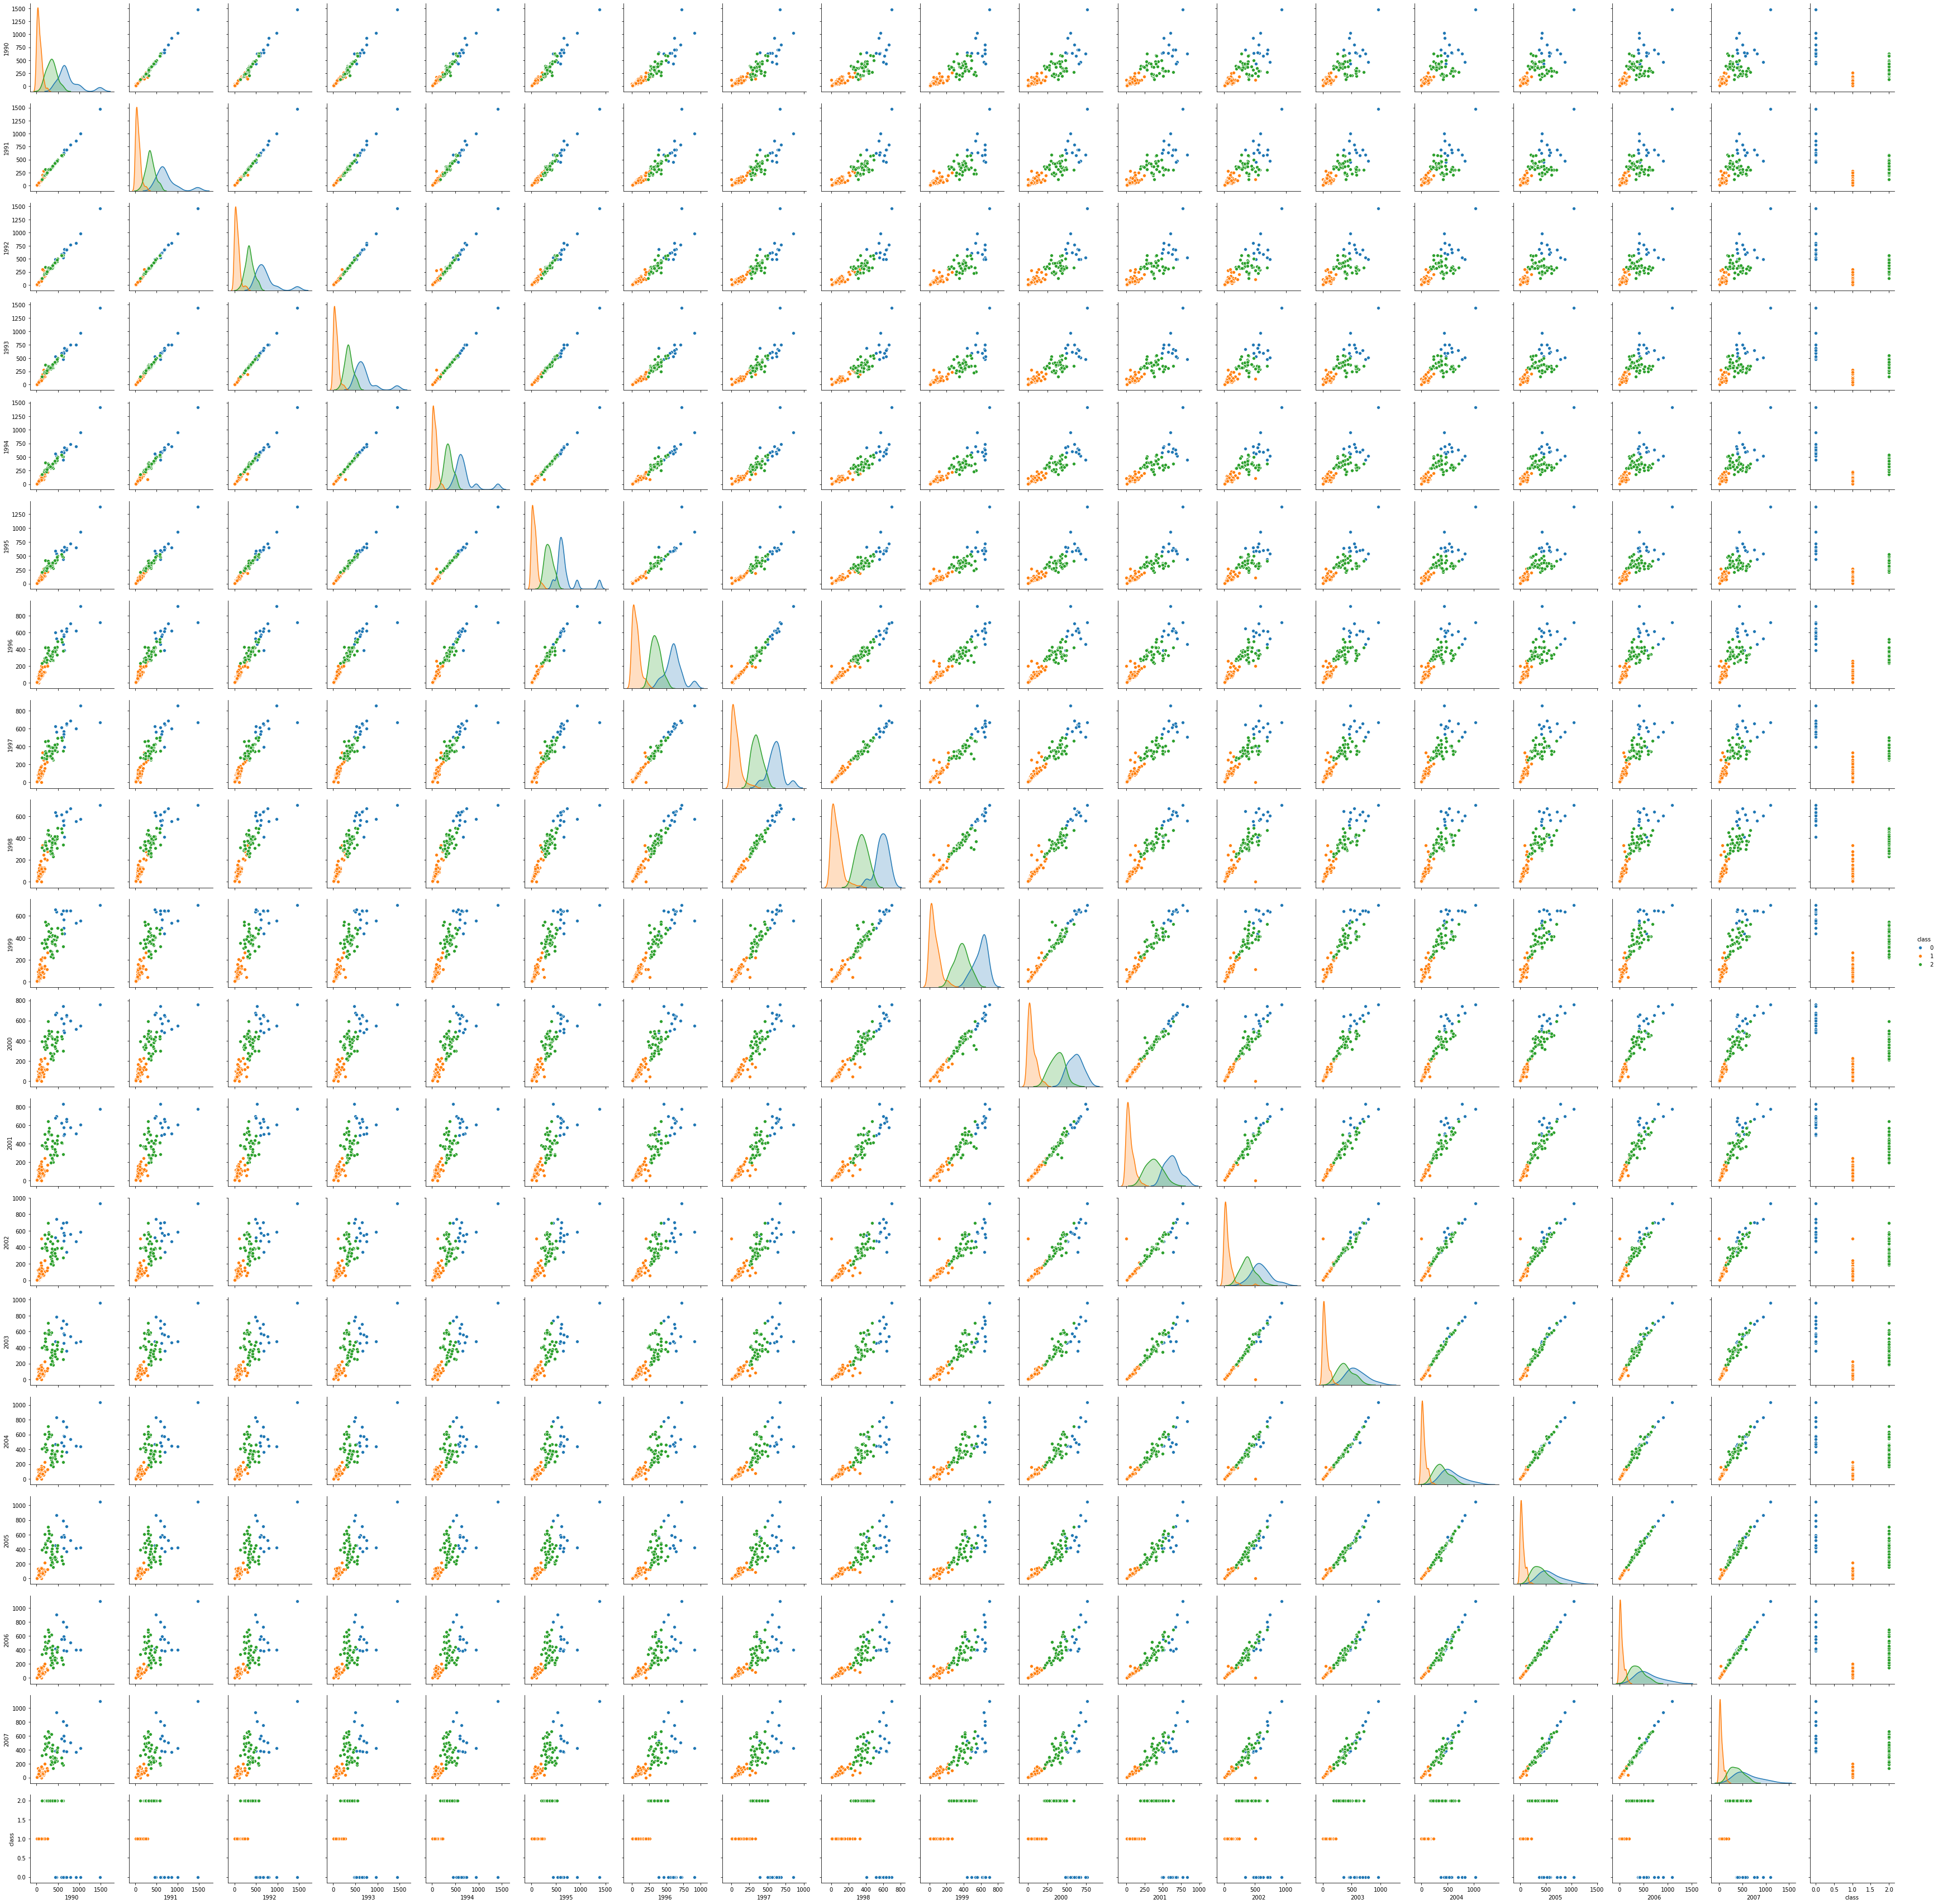

In [33]:
sns.pairplot(df,hue='class',diag_kind='kde')

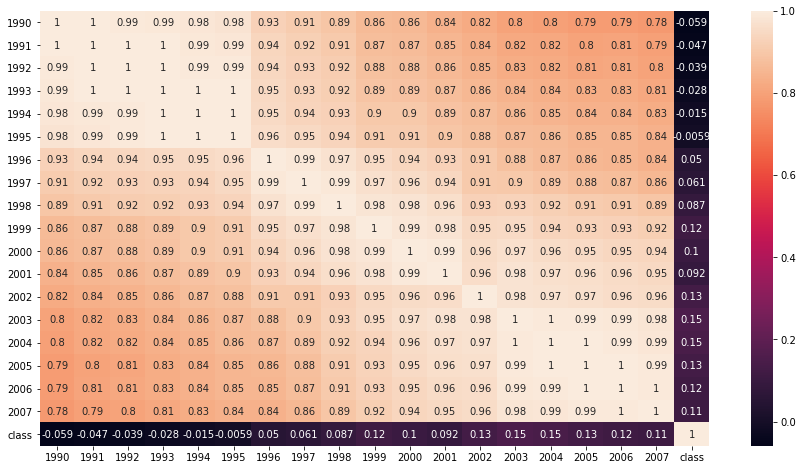

In [35]:
fig , axis = plt.subplots(figsize = (15,8))
sns.heatmap(corr, annot = True)
plt.show()

WE are using pair plot and correlation heatmap to check intra feature relations. We can see high correlation in the year-wise data from the heatmap visually. From the pair plot we can infer that the three classes are very well distributeed on the basis of TB calculation of each year.

## Dimensionality Reduction.

**How to decide when to apply PCA based on the correlation:**

In [36]:
df[['1990','1991','1992']].corr() 

,1990,1991,1992
1990,1.000000,0.997189,0.992784
1991,0.997189,1.000000,0.998379
1992,0.992784,0.998379,1.000000


***Taking example of three years we can find high correlation in the data hence many are redundant features. PCA can therefore be used to reduce the excess noise from the data. Hence we'll apply PCA and retain upto 95% variance of the data for dimensionality reduction and better Signal to Noise Ratio(SNR).***

**Applying PCA:**

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [43]:
X=df.iloc[:,1:19]  #standardising data before applying PCA
cols=X.columns
X = StandardScaler().fit_transform(X)
X=pd.DataFrame(X,columns=cols)

In [44]:
X.head()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
0,-0.614746,-0.615878,-0.604477,-0.604925,-0.617116,-0.648068,-0.715525,-0.745026,-0.769974,-0.769639,-0.754876,-0.743829,-0.750760,-0.737317,-0.728779,-0.731639,-0.725827,-0.711397
1,-0.085651,-0.011257,0.049763,0.119661,0.187976,0.251429,0.351309,0.440760,0.541761,0.614251,0.759627,0.872982,1.007569,1.092859,1.129389,1.119753,1.082190,1.047955
2,-0.465404,-0.456085,-0.455187,-0.452851,-0.412431,-0.339010,-0.221138,-0.108119,-0.193446,-0.206958,-0.141156,-0.078927,-0.159886,-0.183142,-0.200521,-0.199364,-0.194057,-0.187725
3,-0.678749,-0.702252,-0.736203,-0.756998,-0.771766,-0.781840,-0.876851,-0.884834,-0.896916,-0.876092,-0.848914,-0.820364,-0.827002,-0.797858,-0.789018,-0.768667,-0.758196,-0.738959
4,-0.828091,-0.836132,-0.837194,-0.841981,-0.849091,-0.860258,-0.928892,-0.941793,-0.949809,-0.926784,-0.893458,-0.868199,-0.869888,-0.839770,-0.826089,-0.810324,-0.799813,-0.780301


In [45]:
pca=PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [46]:
pca.explained_variance_ #variance contribution by each components

array([1.66397304e+01, 1.06637643e+00, 2.40164920e-01, 5.08843529e-02,
       3.94068919e-02, 2.38700904e-02, 1.73844803e-02, 1.54719105e-02,
       9.83264780e-03, 5.68224477e-03, 4.46638722e-03, 2.45035069e-03,
       1.79061831e-03, 1.37403407e-03, 1.00770489e-03, 6.22167000e-04,
       2.02142494e-04, 8.75488986e-05])

In [47]:
pca.explained_variance_ratio_ #ratio of explained variation / total contributors(18) in this case

array([9.18266606e-01, 5.88481808e-02, 1.32535456e-02, 2.80806244e-03,
       2.17467663e-03, 1.31727536e-03, 9.59365767e-04, 8.53820244e-04,
       5.42616490e-04, 3.13575730e-04, 2.46478406e-04, 1.35223056e-04,
       9.88156030e-05, 7.58263244e-05, 5.56103811e-05, 3.43344011e-05,
       1.11552710e-05, 4.83140218e-06])

In [51]:
pca.explained_variance_>1 #explained variance greater that 1

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [50]:
pca.explained_variance_ratio_[:2].sum()*100 #percentage of variance explained by top two principal components

0.9771147869223822

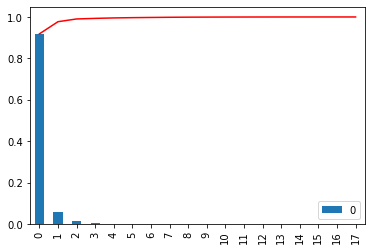

In [58]:
pd.DataFrame(pca.explained_variance_ratio_).plot.bar()
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='r') #cumulative sum of explained variations
plt.show()

Explaination:

pca.explained_variance gives the variance explained by each eigen values. We noted that eigenvalue of all components higher than 2 is less than 1(i.e. these components are not even accounting for the variation of a column). **hence,we selected first two components.**

pca.explained_variance_ratio gives the proportion of variance explained by each of the components. Hence , for the first component, percent of variance explained is (17.71/18.12) = 97.71%

In [57]:
pca.explained_variance_[:2].sum()/pca.explained_variance_.sum()*100

97.7114786922382

In [59]:
pca=PCA(n_components=2) #pca 2 components
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [60]:
pd.DataFrame(pca.components_.T,index=cols,columns=[['PC1','PC2']]) #2 components and their relation with features

,PC1,PC2
1990,0.228300,0.337651
1991,0.231154,0.316886
1992,0.232574,0.304301
1993,0.234419,0.282216
1994,0.236062,0.253358
1995,0.237776,0.228085
1996,0.237735,0.142674
1997,0.238681,0.083776
1998,0.240718,0.004213
1999,0.239793,-0.080743


We can see contribution from almost every feature.

In [66]:
pca = PCA(n_components=2) #fitting ith top 2 vars
X = pca.fit_transform(X)

In [68]:
X=pd.DataFrame(X,columns=['PC1','PC2'])

In [69]:
X.head() #boiled down to only two features hence a huge dimensionality reduction with 97% explained variance 

,PC1,PC2
0,-2.969486,0.195390
1,2.497018,-1.781377
2,-1.092357,-0.446503
3,-3.376462,0.064713
4,-3.652555,-0.050841


### Clustering: Use PCA dimensions to cluster the data. Using K-means and Agglomerative clustering.

### Steps of clustering:
**a. Find the optimal K Value.**\
**b. Applying Clustering and find out if the data points have been clustered correctly using appropriate
visualization.**\
**c. Evaluating the clusters formed using appropriate metrics to support the model built and compare
both the models.**

**Applying Elbow method on WCSS score to find ideal K(number of clusters) value.**

In [70]:
ssd=[]
sscore=[]
for k in range(2,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    ssd.append([k,kmeans.inertia_])
    ss = silhouette_score(X,kmeans.labels_)
    sscore.append([k, ss])

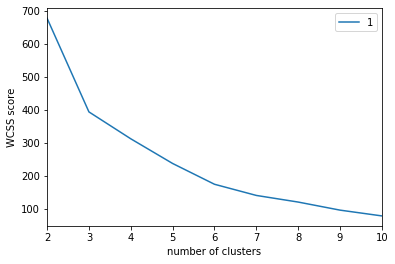

In [72]:
pd.DataFrame(ssd).plot(x=0,y=1)  
plt.ylabel('WCSS score')
plt.xlabel('number of clusters')
plt.show()

***From the above graph it is evident that k=3 clusters is ideal.***

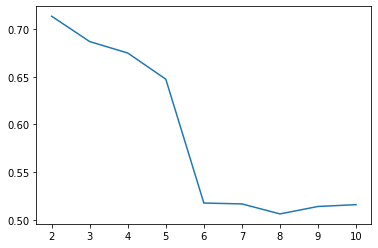

In [73]:
sscore=pd.DataFrame(sscore,columns=['k','sscore'])
plt.plot(sscore['k'],sscore['sscore'])
plt.show()

We can see a good silhouette score at k=3

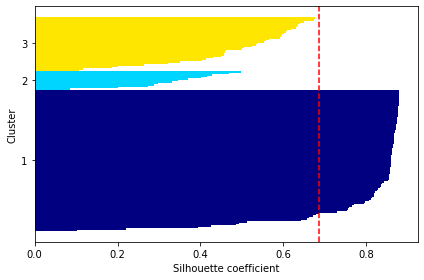

In [78]:
pm.svisualizer(X,3) #silhouette coefficient visualisation, one cluster is very big in size

**Applying clustering using k=3 by kmeans method. Also checking visually how the points are clustered:-**

In [79]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [80]:
X['cluster']=kmeans.labels_ #assigning labels to clusters specifically

In [81]:
X.head()

,PC1,PC2,cluster
0,-2.969486,0.195390,1
1,2.497018,-1.781377,2
2,-1.092357,-0.446503,1
3,-3.376462,0.064713,1
4,-3.652555,-0.050841,1


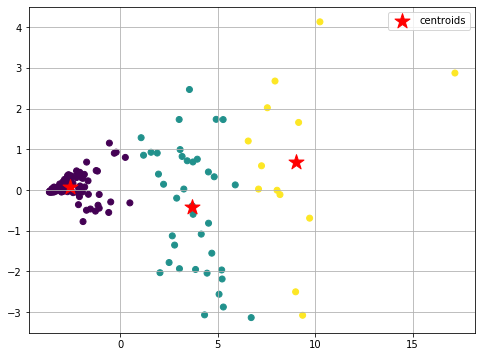

In [82]:
pm.cluster_plot(X.values,3) #kmeans k=3 clustering with centroids in 2D plane.

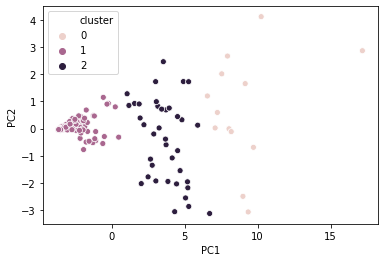

In [83]:
sns.scatterplot(X['PC1'],X['PC2'],hue=X['cluster']) #clustering using two PCA columns

***Agglomerative clustering***

In [86]:
X_agg=X.drop('cluster',axis=1)

In [84]:
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

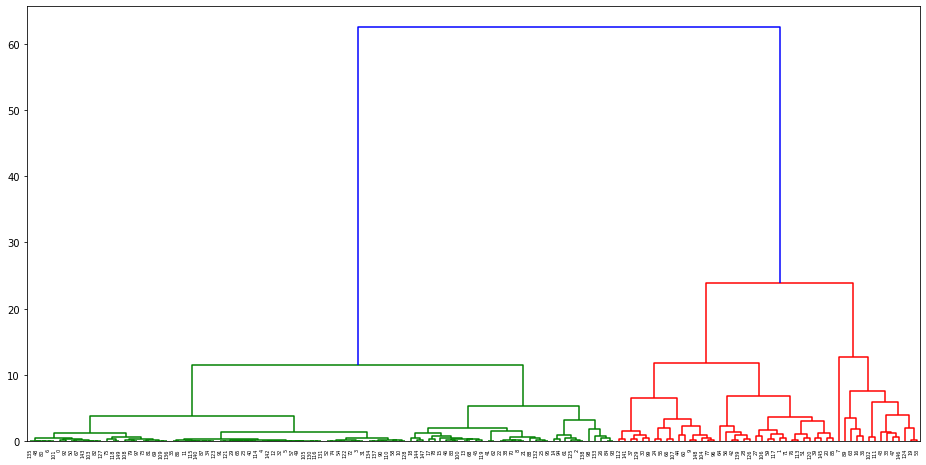

In [88]:
plt.figure(figsize=(16,8))
mergings=linkage(X_agg, method='ward')
dendrogram(mergings)
plt.show()

We are getting 3 cluster formation if we cut the tree from 20 distance unit. We'll cut and apply the clustering and visualise the results.

In [89]:
cut = pd.Series(cut_tree(mergings, n_clusters=3).reshape(-1,))
X_agg['cluster']=cut

In [91]:
X_agg.head()

,PC1,PC2,cluster
0,-2.969486,0.195390,0
1,2.497018,-1.781377,1
2,-1.092357,-0.446503,0
3,-3.376462,0.064713,0
4,-3.652555,-0.050841,0


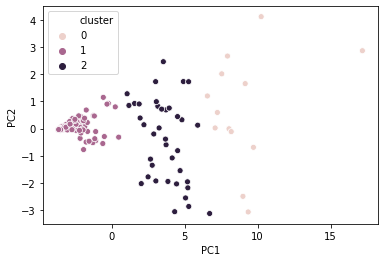

In [90]:
sns.scatterplot(X_agg['PC1'],X_agg['PC2'],hue=X['cluster']) #clustering using two PCA columns

***INFERENCE: Both the clustering methods are doing a very similar job at n=3 level of clustering. We can visually confirm this visually also. We will now evaluate the quality of the clustering.***

### Evaluating And Result

**Checking Within Cluster Sum of Squares(WCSS) for k=3**

In [96]:
ssd[1][1] 

393.7377060018174

WCSS effectively is used to measure the quality of clustering as it reflects the distance between cluster points at a specific value. 393.73 is a low value hence suggests that k=3 is a good kmeans cluster.

**Silhouette Score(at k=3):**

In [100]:
sscore[sscore['k']==3]['sscore']

1    0.686956
Name: sscore, dtype: float64

In [99]:
sscore['sscore'].mean()

0.5881116590303627

Silhouette score mean of top 10 clusters is 58 and silhouette score at k=3 is 68.69 which suggest that it is higher and much better form of clustering.

**We can also check clustering performance by appending the class that was originally provided to us in the data and checking how the clusters are formed based on the class values:**

In [102]:
X['class']=df['class']
X.head()

,PC1,PC2,cluster,class
0,-2.969486,0.195390,1,1
1,2.497018,-1.781377,2,2
2,-1.092357,-0.446503,1,1
3,-3.376462,0.064713,1,1
4,-3.652555,-0.050841,1,1


In [104]:
pd.crosstab(X['cluster'],X['class']).T

cluster,0,1,2
class,,,
0,13,0,0
1,0,99,0
2,0,0,38


**INFERENCE: We can see that all the 3 clusters are perfectly clustered among the 3 class types which means that the clustering  technique is performing exactly as it needed to classify the class. Hence with 100% accurate results the both clustering technqiues are able to find the same results and hence clustering in 3 groups is done correctly.**

### Using the cluster labels from the best method above and convert the problem to a supervised learning classification.

In [105]:
data=X.drop('class',axis=1)

In [106]:
data.head()

,PC1,PC2,cluster
0,-2.969486,0.195390,1
1,2.497018,-1.781377,2
2,-1.092357,-0.446503,1
3,-3.376462,0.064713,1
4,-3.652555,-0.050841,1


features: PC1 and PC2 no redundant features after PCA\
target variable: cluster

In [109]:
X_pca=data.drop('cluster',axis=1)

In [110]:
y_pca=data['cluster']

In [112]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.3)

**Checking if both train and test representative of the overall data visually and statistically by using tests.**

In [113]:
from scipy.stats import ttest_ind

Null Hypothesis: Mean0 = Mean1\
Alternate: mean0!=mean1

In [114]:
ttest_ind(X_train_pca['PC1'],X_test_pca['PC1'])

Ttest_indResult(statistic=-0.26481455028425555, pvalue=0.7915207768318393)

In [115]:
ttest_ind(X_train_pca['PC2'],X_test_pca['PC2'])

Ttest_indResult(statistic=1.5191568822620494, pvalue=0.13085638946001507)

We are performing TTest to check significant difference in the means of the Splitted data in train and test.\
We are getting p-values >0.05 HENCE we failed to reject Null Hypothesis.\
Which means there is no significant difference in the means of the TEST and TRAIN data

OTHER METHOD TO CHECK IS DISTRIBUTION ON THE BASIS OF SPLITTING:

In [117]:
X_train_pca['label']=1 #label test and train data
X_test_pca['label']=0

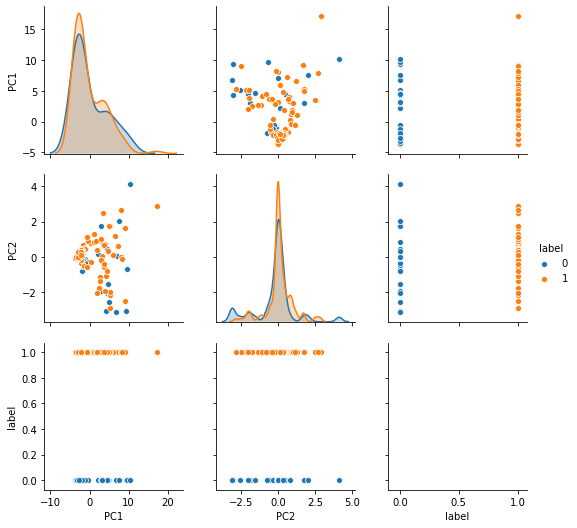

In [119]:
A=pd.concat([X_test_pca,X_train_pca])
sns.pairplot(A,hue='label')

FROM THE PAIRPLOT IT IS VISIBLE THAT: orange and blue distrbutions of almost all the variables are overlapping. Blue is **test data** and orange is **train data**. Distributions are similar hence we can confirm that our data is splitted quite randomly hence giving rise to no anomaly and bias.

Method-flow: Apply classification model on non-PCA, get the best accuracy. And apply Classification model on PCA data to get the best accuracy and check which model is performing better.

In [124]:
X=df.iloc[:,1:19]
cols=X.columns
X = StandardScaler().fit_transform(X)
X=pd.DataFrame(X,columns=cols)
y=df['class']

In [125]:
X.head()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
0,-0.614746,-0.615878,-0.604477,-0.604925,-0.617116,-0.648068,-0.715525,-0.745026,-0.769974,-0.769639,-0.754876,-0.743829,-0.750760,-0.737317,-0.728779,-0.731639,-0.725827,-0.711397
1,-0.085651,-0.011257,0.049763,0.119661,0.187976,0.251429,0.351309,0.440760,0.541761,0.614251,0.759627,0.872982,1.007569,1.092859,1.129389,1.119753,1.082190,1.047955
2,-0.465404,-0.456085,-0.455187,-0.452851,-0.412431,-0.339010,-0.221138,-0.108119,-0.193446,-0.206958,-0.141156,-0.078927,-0.159886,-0.183142,-0.200521,-0.199364,-0.194057,-0.187725
3,-0.678749,-0.702252,-0.736203,-0.756998,-0.771766,-0.781840,-0.876851,-0.884834,-0.896916,-0.876092,-0.848914,-0.820364,-0.827002,-0.797858,-0.789018,-0.768667,-0.758196,-0.738959
4,-0.828091,-0.836132,-0.837194,-0.841981,-0.849091,-0.860258,-0.928892,-0.941793,-0.949809,-0.926784,-0.893458,-0.868199,-0.869888,-0.839770,-0.826089,-0.810324,-0.799813,-0.780301


In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**APPLYING KNeighbors Classifier on NON_PCA DATA**

In [143]:
#training the Model:

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [144]:
y_pred = knn.predict(X_test)

score = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)

In [145]:
score*100 #score on test data

95.55555555555556

In [146]:
cm #confusion matrix

array([[ 3,  0,  2],
       [ 0, 33,  0],
       [ 0,  0,  7]], dtype=int64)

In [148]:
knn.score(X_train,y_train)*100 #score on train data

100.0

KNN is performing well on NON_PCA DATA

**APPLYING RANDOM FOREST ON NON_PCA data:**

In [127]:
# Training the Model:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit (X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [140]:
y_pred = rf.predict(X_test)

score = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)

In [141]:
score*100

100.0

In [142]:
cm

array([[ 5,  0,  0],
       [ 0, 33,  0],
       [ 0,  0,  7]], dtype=int64)

APPLYING CROSS VALIDATION:

In [152]:
scoresdt = cross_val_score(rf, X,y, cv=10)

In [153]:
scoresdt

array([1.        , 0.9375    , 1.        , 1.        , 1.        ,
       1.        , 0.93333333, 0.93333333, 1.        , 1.        ])

In [175]:
scoresdt.mean()*100 #average accuracy

98.75

In [156]:
scoresdt.std() #deviation from mean

0.029933375092769682

INFERENCE: We can infer that when we apply classification model on NON-PCA data our model is working very nicely and we are getting very high accuracy values upto 100%. Upon cross validation we are able to secure 98.04 average accuracy with a very low standard deviation. We'll now check how PCA data classification models are working and we'll draw overall inferences.

**APPLYING CLASSIFICATION MODEL ON PCA DATA:**

In [157]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.3)

In [158]:
X_train_pca.head()

,PC1,PC2
57,-3.590490,-0.033031
21,-2.260704,0.305054
19,8.043115,-0.006006
51,3.253441,0.023817
54,-3.350626,0.011272


**APPLYING LGBM CLASSIFIER ON PCA DATA:**

In [160]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(X_train_pca, y_train_pca)
print('Accuracy score using LGBM: ',lgbm.score(X_test_pca,y_test_pca)) #score on test data

Accuracy score using LGBM:  0.9555555555555556


In [161]:
y_pred = lgbm.predict(X_test_pca)
score = accuracy_score(y_test_pca,y_pred)
cm = confusion_matrix(y_test_pca,y_pred)

In [162]:
cm

array([[ 3,  0,  2],
       [ 0, 33,  0],
       [ 0,  0,  7]], dtype=int64)

In [163]:
lgbm.score(X_train_pca,y_train_pca) #accuracy on train data

0.9333333333333333

**APPLYING RANDOM FOREST CLASSIFIER ON PCA DATA:**

In [164]:
# Training the Model:
rf_pca = RandomForestClassifier()
rf_pca.fit (X_train_pca, y_train_pca)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [165]:
y_pred = rf_pca.predict(X_test_pca)

score = accuracy_score(y_test_pca,y_pred)
cm = confusion_matrix(y_test_pca,y_pred)

In [166]:
score*100

100.0

In [167]:
cm

array([[ 5,  0,  0],
       [ 0, 33,  0],
       [ 0,  0,  7]], dtype=int64)

APPLYING CROSS VALIDATION:

In [170]:
scoresdt = cross_val_score(rf_pca, X_pca,y_pca, cv=10)

In [171]:
scoresdt

array([1.    , 0.9375, 0.9375, 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    ])

In [174]:
scoresdt.mean()*100 #average accuracy

98.75

In [173]:
scoresdt.std() #deviation from mean

0.025

INFERENCE: The best performing model is a random forest on PCA data. With maximum accuracy as 100% and average cross validation score on whole data as 98.75.

###  Summary
**Comparing all the classification models built and clustering:**

**We've applied clustering techniques on PCA data and classification models on both PCA and non_PCA data.\ 
In case of clustering:\
Both Kmeans and Agglomerative clustering were giving good clusters at n=3. WCSS and Silhouete scores can be referred to check the quality of the clustering techniques. A crosstab is also built to comapre clustered data with original class that was available in the data and with 100% accurate clustering we can convincingly say that our clustering model was built perfectly.\
In case of classification modelling:\
The overall fit of the model was checked with multiple classification techniques like KNN, LGBM and Random Forest on both PCA and non_PCA data.\
The model was performing with high accuracy in both PCA and non_PCA data specifically with random forest ensemble learning technique. Random Forest with PCA can be declared as a better model because, It is giving better cross validation scores with a very low standard deviation in scores as low as 2.5. Hence we can confirm a good fit of the modelling.**

**Business interpretation/explanation of the model.**

The classification or clustering modelling techniques can be used to by government health departments. Or worldwide health organisations like WHO or United Nations health department. This model can help classification or various other countries on the basis of similar data and can be classified in the three cluster(class). When deployed the model will be capable of this with a very good accuracy as seen above. Hence there are various business implications and interpretations of this model that can be used world wide by different Non-profit/Profit organisations for the benefit of the society.

**Important features with respect to target:**

In [176]:
feature=pd.Series(rf.feature_importances_,index=X.columns)
feature

1990    0.000000
1991    0.055294
1992    0.083721
1993    0.048821
1994    0.000000
1995    0.108929
1996    0.141740
1997    0.003323
1998    0.003267
1999    0.117042
2000    0.125271
2001    0.000000
2002    0.000000
2003    0.156142
2004    0.070494
2005    0.000000
2006    0.073836
2007    0.012120
dtype: float64

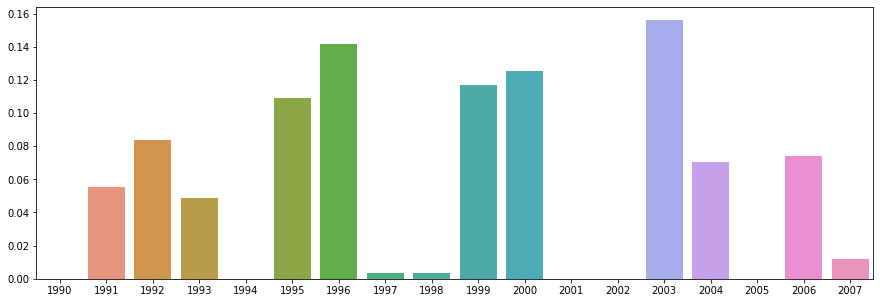

In [177]:
plt.figure(figsize=(15,5))
sns.barplot(feature.index,feature.values)
plt.show()

Checking feature importances to check data of which year is impacting the class target variable the most.\
From the above graph chart it is evident that the year: 2003,1996,1995,1999,2000,2006 and 1992 features are effecting the target classification the most.

**CLASS PROFILING ON THE BASIS of important year data:**

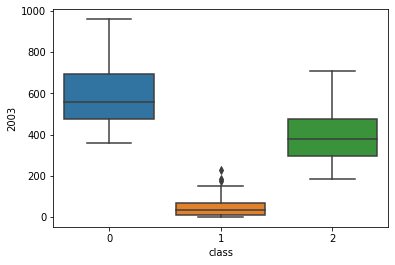

In [179]:
sns.boxplot(df['class'],df['2003'])

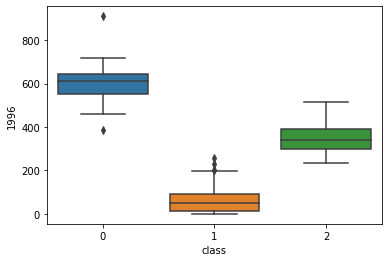

In [180]:
sns.boxplot(df['class'],df['1996'])

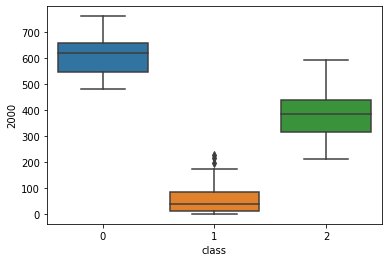

In [181]:
sns.boxplot(df['class'],df['2000'])

***Checking the yearwise data with class, we can understand that class 0 has high cases, class 1 has low number of TB cases and class 2 has medium number of TB cases.***

#### Changes and impact(summarised):\
1) Clustering: Applying two type of clustering method gave an idea about the ideal number of clusters. Two methods were used to compete and the best clustering method gave a 100% accurate clustering result.\
2) PCA: PCA was done to reduce the noise of the final model.\
3) Comparison and cross validation: Applying various models on both pca and non_pca and cross_validation to check the best performing model with higher accuracy hence obtaining a sophisticated model over the base simple clustering technique.

**Risks:**

The major risk factor involved are the error. There are two types of error type I and type II. The risk resonates on the problem of misclassification or misclustered points. The problem with ERROR in our model will put some countries in other country groups. For example countries with very high TB prevalence, is misclassified as low TB prevalence then correct actions by the country will not be taken to fight TB. Hence risks resonates with error rate of the model.